# Imports

In [1]:
import os
import random
import requests

import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

# Task description

Since we want to get a better understanding of your Python skills and how you approach a task, we ask you to send us a solution for this coding task till March, 3rd 2021, 10 am CET.

Imagine we have a new customer who provides us a small dataset and wants to get some insights about his fleet.

Your task is to perform a little data exploration on the provided data and then apply simple anomaly detection techniques. <br>
Support your findings with plots, when possible and when it makes sense. <br>
Do not forget to comment your code and write a final conclusion when you are done.

As a dataset for this small task, we use data of trains operating in Finland, which is accesible through an API (https://www.digitraffic.fi/en/railway-traffic/).

For a fast start, we provide some examples how you can query data: 

In [2]:
# live data for the current trains
live_api = 'https://rata.digitraffic.fi/api/v1/live-trains/'

# data for one train and one particular date
train_day_api = 'https://rata.digitraffic.fi/api/v1/trains/2021-02-01/4'

# data for one particular day for all trains
day_api = 'https://rata.digitraffic.fi/api/v1/trains/2021-02-01'

In [3]:
#data = pd.read_json(requests.get(live_api).text)
#data = pd.read_json(requests.get(train_day_api).text)
data = pd.read_json(requests.get(day_api).text)
data.head()

,trainNumber,departureDate,operatorUICCode,operatorShortCode,trainType,trainCategory,commuterLineID,runningCurrently,cancelled,version,timetableType,timetableAcceptanceDate,timeTableRows
0,1,2021-02-01,10,vr,IC,Long-distance,,False,False,276769881393,REGULAR,2020-11-06T10:17:00.000Z,"[{'stationShortCode': 'HKI', 'stationUICCode':..."
1,2,2021-02-01,10,vr,S,Long-distance,,False,False,276768326837,REGULAR,2020-12-18T11:03:54.000Z,"[{'stationShortCode': 'JNS', 'stationUICCode':..."
2,3,2021-02-01,10,vr,IC,Long-distance,,False,False,276772188938,REGULAR,2020-08-20T10:15:10.000Z,"[{'stationShortCode': 'HKI', 'stationUICCode':..."
3,4,2021-02-01,10,vr,IC,Long-distance,,False,False,276770864708,REGULAR,2020-12-18T11:03:54.000Z,"[{'stationShortCode': 'JNS', 'stationUICCode':..."
4,5,2021-02-01,10,vr,IC,Long-distance,,False,False,276774574292,REGULAR,2020-11-06T10:17:00.000Z,"[{'stationShortCode': 'HKI', 'stationUICCode':..."


# Your Approach

Perform the following steps:
1. Load the data from the API (use at least one month of data)
2. Perform data exploration to get a better understanding of the data, which information is it providing and describe what you find. 
    - See this step also as preparation for the next one
    - Consider that the column 'timeTableRows' contains further, embedded information
    - Important aspects could also be cancellations, delays and their causes


3. Try to find anomalies taking into account: 
    - Number of stations on the way
    - Total time from entry point to final destination

## Dataset preparation
- Create functions in order to do feature engineering
- Retrieve data from API and store everything in pandas dataframe

In [2]:
def get_total_journey_time(df: pd.DataFrame):
    
    colNames = df.columns

    if('actualTime' in colNames):

        start = df['actualTime'].iloc[0]
        end = df['actualTime'].iloc[-1]
        
        if(type(start) != str):
            return np.nan
        if(type(end) != str):
            return np.nan

        start = start.replace("T", " ").split('.')[0]
        startTime = datetime.fromisoformat(start)

        end = end.replace("T", " ").split('.')[0]
        endTime = datetime.fromisoformat(end)

        time_delta = (endTime - startTime)
        total_seconds = time_delta.total_seconds()
        minutes = total_seconds / 60

        return minutes

    else:
        return np.nan 

In [3]:
def cross_country(df: pd.DataFrame) -> bool:
    
    retval = False
    
    if(df['countryCode'].nunique() > 1):
        retval = True
    
    return retval   

In [4]:
def get_total_delay(df: pd.DataFrame) -> float:
    
    retval = np.inf

    colNames = df.columns
    if('differenceInMinutes' in colNames):
        retval = df['differenceInMinutes'].iloc[-1]

    return retval      

In [5]:
def get_total_stops(df: pd.DataFrame) -> int:
    
    return int(df['trainStopping'].value_counts()[True] / 2)        

In [6]:
def was_cancelled(df: pd.DataFrame) -> bool:
    
    retval = False
       
    if(df['cancelled'].nunique() > 1):
        retval = True
    
    return retval

In [7]:
def get_cause(df: pd.DataFrame) -> list:
    
    flat_list = [item for sublist in df['causes'].tolist() for item in sublist]
    
    return flat_list

In [8]:
days = pd.date_range(start='20210101',end='20210131',freq='D').strftime('%Y-%m-%d').tolist()
api = 'https://rata.digitraffic.fi/api/v1/trains/'

dataframes = []
numStations = []
totalDelay = []
crossCountry = []
totalTime = []
totalStops = []
cancelled = []
causes = []

for day in tqdm(days):
    data = pd.read_json(requests.get(os.path.join(api, day)).text)
    
    timeTableRows = data.iloc[:, -1]
    
    for i in range(len(timeTableRows)):
        timeTable = timeTableRows.to_dict()[i]
        timeTableDF = pd.DataFrame(timeTable)
        
        numStations.append(int(timeTableDF.shape[0]/2))
        totalDelay.append(get_total_delay(timeTableDF))
        crossCountry.append(cross_country(timeTableDF))
        totalTime.append(get_total_journey_time(timeTableDF))        
        totalStops.append(get_total_stops(timeTableDF))
        cancelled.append(was_cancelled(timeTableDF))
        causes.append(get_cause(timeTableDF))        
    
    data['numStations'] = pd.Series(numStations)
    data['totalDelay'] = pd.Series(totalDelay)
    data['crossCountry'] = pd.Series(crossCountry)
    data['totalTime (minutes)'] = pd.Series(totalTime)
    data['totalStops'] = pd.Series(totalStops)
    data['cancelled2'] = pd.Series(cancelled)
    data['causes'] = pd.Series(causes)
    
    dataframes.append(data)    
    
data = pd.concat(dataframes)

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [02:24<00:00,  4.65s/it]


In [9]:
print("Data shape: ", data.shape)

Data shape:  (51812, 20)


## Dataset cleaning
- drop columns which are not needed for anomaly detection (mainly, numerical features are kept)
- drop observations which include NaN values

In [10]:
X = data.copy()

drop_col = ['trainNumber', 'departureDate', 'operatorUICCode', 'operatorShortCode', 'trainType', 'trainCategory', 
            'commuterLineID', 'runningCurrently', 'version', 'timetableType', 'timetableAcceptanceDate',
            'timeTableRows', 'causes', 'crossCountry', 'cancelled2', 'cancelled']

X.drop(labels=drop_col, axis=1, inplace=True)
X.dropna(axis=0, inplace=True)
X.shape

(44593, 4)

## Data exploration
- Idea: Get intuition about feature correlation
- Reduce dimensionality and see whether data anomalies can be already suspected in 2D plot (PCA)

### Feature distribution and correlation

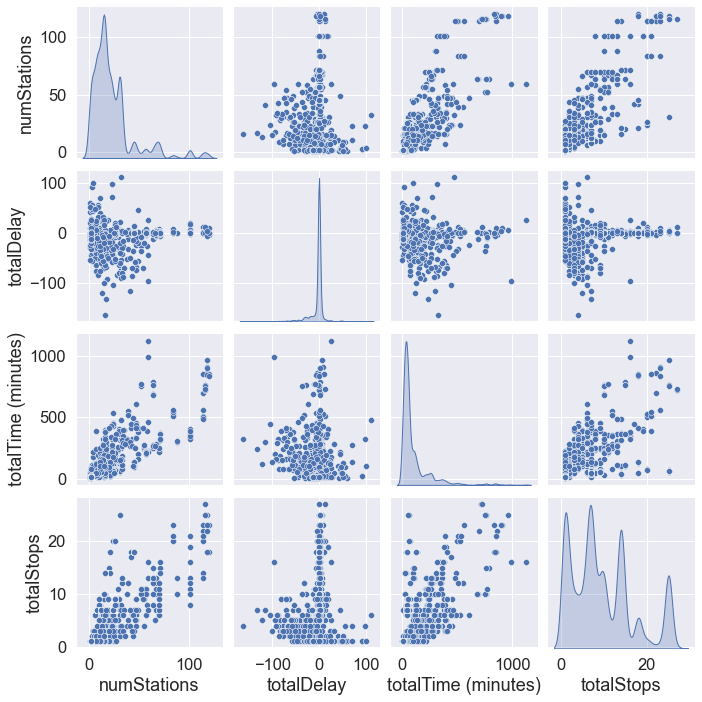

In [12]:
sns.pairplot(X,diag_kind='kde',height = 2.5)
sns.set(font_scale = 1.5)

**Looking on the lower triangular matrix of the repesented plot above, it can be seen that there is a positive correlation between**

- numStations - totalStops
- totalTime (minutes) - totalStops
- numStations - totalTime (minutes)

### Principle Component Analysis (PCA)

In [13]:
X.head()
pca = PCA(n_components=X.shape[1])
X_trans = pca.fit_transform(X)

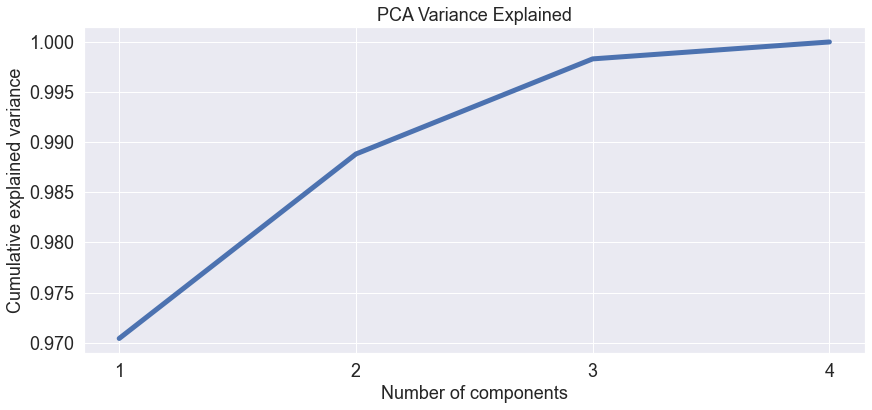

In [24]:
sval = pca.singular_values_ #gives you the sorted singular values
principal_components = np.arange(len(sval))+1
fontsize = 18

plt.figure(figsize=(14,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=5)
plt.title("PCA Variance Explained", fontsize=fontsize)
plt.xlabel('Number of components', fontsize=fontsize)
plt.ylabel('Cumulative explained variance', fontsize=fontsize)
plt.xticks(np.arange(len(sval)), principal_components, fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.show()

**From the plot above I can conclude, using the current feature set, that the first two componenents are enough to reduce dimensionality, while not loosing to much information: ~99% of data variance is preserved!**

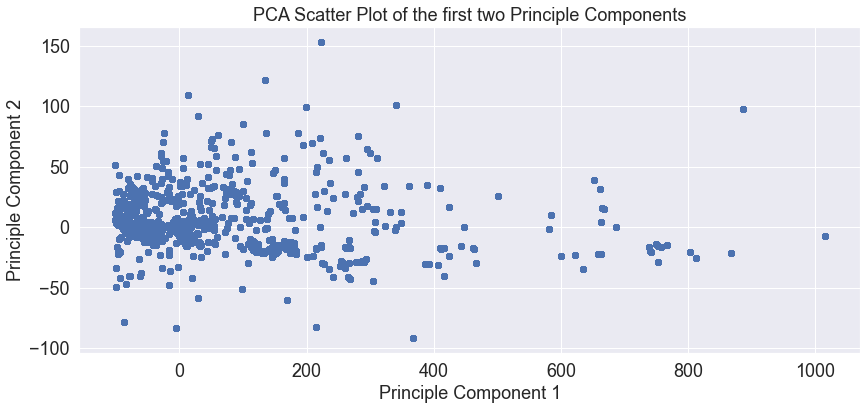

In [25]:
fontsize = 18

plt.figure(figsize=(14,6))
plt.scatter(X_trans[:,0], X_trans[:,1])
plt.title("PCA Scatter Plot of the first two Principle Components", fontsize=fontsize)
plt.xlabel('Principle Component 1', fontsize=fontsize)
plt.ylabel('Principle Component 2', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.show()

**In this plot, one might already suspect which region of the plot contains most of the outliers. As the point cloud on the left is rather dense, I would suspect that the anomal datapoints are most likely on the right half plane and somewhere around the dense datapoints with cluster center (0,0).** 

## Anomaly detection

What I know so far about IsolationForests, they can be sensitive to the amout of training data. In order to investigate the bahaviour of the IsolationForest, different training set sizes are evaluated. Each training set size is evaluated 10 times. The respective samples are chosen randomly. 

In [26]:
train_size = [500, 2500, 5000, 10000, 20000, 25000, 40000, X.shape[0]]

anomaly_dict = {}

for size in tqdm(train_size):   
    anomalies = []
    for i in range(10):
        randomlist = random.sample(range(0, X.shape[0]), size)
        clf = IsolationForest(random_state=0).fit(X.iloc[randomlist])
        result = clf.predict(X)
        anomal_index = np.where(result==-1)
        anomalies.append(len(anomal_index[0]))  
    
    anomaly_dict[size] = anomalies    

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:13<00:00,  9.23s/it]


In [27]:
anomaly = pd.DataFrame(anomaly_dict).transpose()
anomaly['mean'] = anomaly.mean(axis=1).astype(int)
anomaly['std'] = anomaly.std(axis=1).astype(int)
anomaly.head(len(train_size))

,0,1,2,3,4,5,6,7,8,9,mean,std
500,6727,7827,6011,7425,7732,6843,7834,7907,7868,7926,7410,626
2500,7728,7198,6700,6648,6852,7235,7437,8010,6888,7920,7261,473
5000,7152,7742,6644,6391,8045,7363,7695,7856,6934,6284,7210,598
10000,7030,7024,6043,7363,7596,7692,7126,7307,7776,7698,7265,487
20000,6744,7620,6919,6821,7799,7419,7763,7333,7492,7244,7315,360
25000,6385,6682,6522,6856,7188,7061,7683,6753,7608,7145,6988,410
40000,7234,8387,7768,7397,7554,7493,7249,6947,7290,7579,7489,368
44593,6179,6788,7208,7543,6212,7038,7002,7048,7433,6551,6900,443


**From the table above, I can conclude that, generally, the size of the training set for the IsolationForest does not play a big role in this case. Nevertheless, according to the lowest standard deviation while using 20000 samples, I will choose 20000 randomly sampled datapoints in order to train the IsolationForest.**

### Train IsolationForest on 20000 data samples and make predictions for all datapoints

In [28]:
randomlist = random.sample(range(0, X.shape[0]), 20000)

clf = IsolationForest(random_state=0).fit(X.iloc[randomlist])
results = clf.predict(X)
results = pd.Series(results)
results.shape

(44593,)

### Get indices of normal and anomal data and show some statistics

In [33]:
anomal_index = np.where(results == -1)
normal_index = np.where(results == 1)
anomal_index = anomal_index[0].tolist()
normal_index = normal_index[0].tolist()
print("Number normal: ", len(normal_index))
print("Number anomal: ", len(anomal_index))
print("Ratio Anomal/Total: {:.2f} %".format(len(anomal_index)/result.shape[0]*100))

Number normal:  37283
Number anomal:  7310
Ratio Anomal/Total: 16.39 %


### Slice original data into normal and anomal data parts

In [34]:
anomalData = X.iloc[anomal_index]
normalData = X.iloc[normal_index]
print(anomalData.shape)
print(normalData.shape)

(7310, 4)
(37283, 4)


### PCA plot after anomality detection

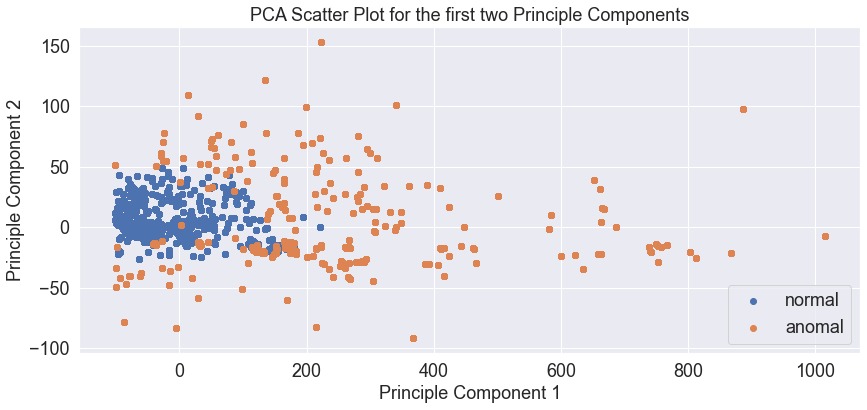

In [35]:
X_normal = pca.transform(normalData)
X_anomal = pca.transform(anomalData)
fontsize = 18

plt.figure(figsize=(14,6))
plt.scatter(X_normal[:,0], X_normal[:,1], label="normal")
plt.scatter(X_anomal[:,0], X_anomal[:,1], label="anomal")
plt.title("PCA Scatter Plot for the first two Principle Components", fontsize=fontsize)
plt.xlabel('Principle Component 1', fontsize=fontsize)
plt.ylabel('Principle Component 2', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(loc="lower right", prop={'size': 18})
plt.show()

**The suspection from the first PCA plot, that the anomal datapoints are most likely on the right half plane and somewhere around the dense cluster center at (0,0),  can be confirmed. In this case, the blue and very dense datapoints are representing normal datapoint according to the IsolationForest. The orange datapoints show outliers.**

---

# In-depth investigation of the original data with all features
The original data is sliced by using the indices of the anomal datapoints obtained by the IsolationForest

In [36]:
data_anomal = data.iloc[anomal_index]
print("Shape: ", data_anomal.shape)
data_anomal.head()

Shape:  (7310, 20)


,trainNumber,departureDate,operatorUICCode,operatorShortCode,trainType,trainCategory,commuterLineID,runningCurrently,cancelled,version,timetableType,timetableAcceptanceDate,timeTableRows,numStations,totalDelay,crossCountry,totalTime (minutes),totalStops,cancelled2,causes
0,1,2021-01-01,10,vr,IC,Long-distance,,False,False,276359363267,REGULAR,2020-11-06T10:17:00.000Z,"[{'stationShortCode': 'HKI', 'stationUICCode':...",67,-4.0,False,277.816667,12,False,[]
1,3,2021-01-01,10,vr,IC,Long-distance,,False,False,276361055203,REGULAR,2020-08-20T10:15:10.000Z,"[{'stationShortCode': 'HKI', 'stationUICCode':...",67,-5.0,False,264.600000,11,False,[]
3,5,2021-01-01,10,vr,IC,Long-distance,,False,False,276362756815,REGULAR,2020-11-06T10:17:00.000Z,"[{'stationShortCode': 'HKI', 'stationUICCode':...",67,-6.0,False,263.833333,11,False,[]
4,6,2021-01-01,10,vr,IC,Long-distance,,False,False,276360446435,REGULAR,2020-11-06T10:17:00.000Z,"[{'stationShortCode': 'JNS', 'stationUICCode':...",67,2.0,False,278.566667,12,False,[]
7,9,2021-01-01,10,vr,IC,Long-distance,,False,False,276605740047,REGULAR,2020-11-06T10:17:00.000Z,"[{'stationShortCode': 'HKI', 'stationUICCode':...",67,-5.0,False,272.000000,12,False,"[{'categoryCode': 'L', 'detailedCategoryCode':..."


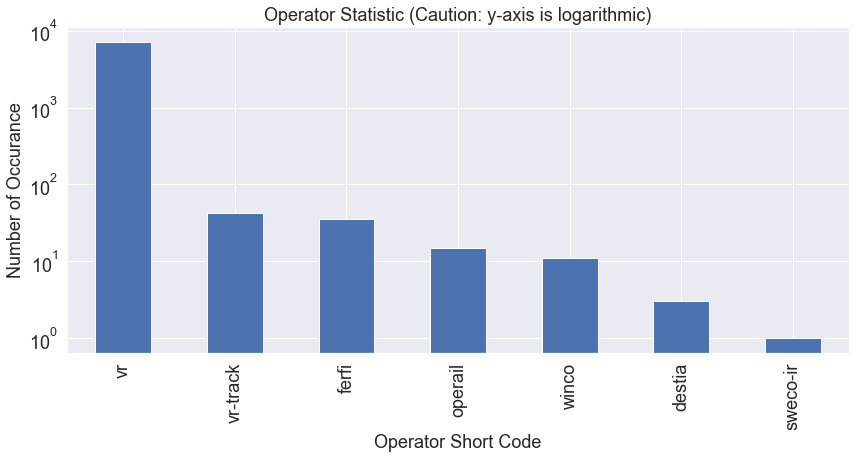

In [37]:
plt.figure(figsize=(14,6))
ax = data_anomal['operatorShortCode'].value_counts().plot(kind='bar')
ax.set(yscale="log")
plt.title("Operator Statistic (Caution: y-axis is logarithmic)", fontsize=fontsize)
plt.xlabel('Operator Short Code', fontsize=fontsize)
plt.ylabel('Number of Occurance', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.show()

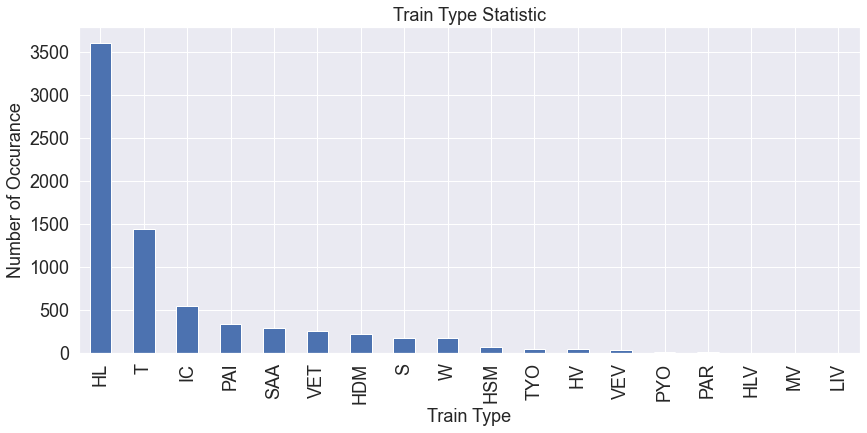

In [38]:
plt.figure(figsize=(14,6))
ax = data_anomal['trainType'].value_counts().plot(kind='bar')
#ax.set(yscale="log")
plt.title("Train Type Statistic", fontsize=fontsize)
plt.xlabel('Train Type', fontsize=fontsize)
plt.ylabel('Number of Occurance', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.show()

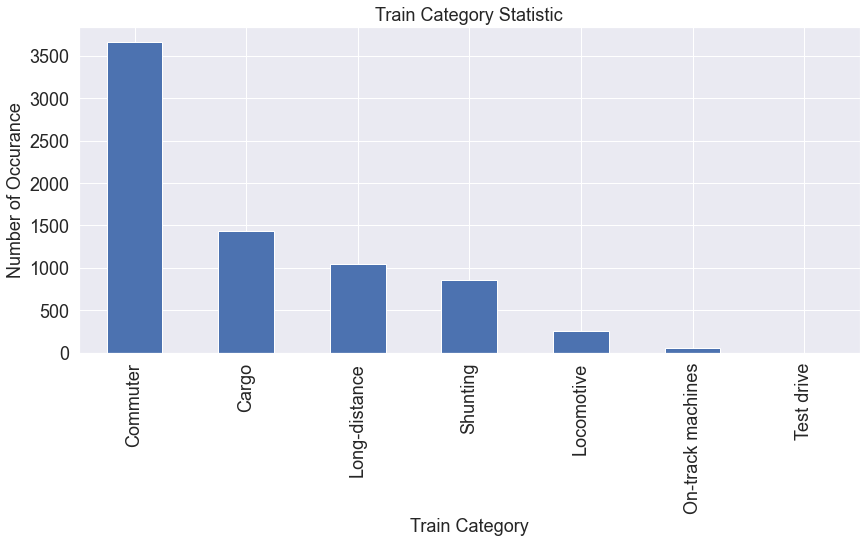

In [39]:
plt.figure(figsize=(14,6))
ax = data_anomal['trainCategory'].value_counts().plot(kind='bar')
#ax.set(yscale="log")
plt.title("Train Category Statistic", fontsize=fontsize)
plt.xlabel('Train Category', fontsize=fontsize)
plt.ylabel('Number of Occurance', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.show()

**From the three bar plots above, it can be seen that the operator "vr", the train type "HL" and the train category "Commuter" are often concerned to be anomal. As a consequence, those specific observations are investigated in more detail.**

---

# Operator "vr"

In [40]:
vr = data_anomal[data_anomal['operatorShortCode'] == "vr"]
print("Shape: ", vr.shape)
vr.head()

Shape:  (7203, 20)


,trainNumber,departureDate,operatorUICCode,operatorShortCode,trainType,trainCategory,commuterLineID,runningCurrently,cancelled,version,timetableType,timetableAcceptanceDate,timeTableRows,numStations,totalDelay,crossCountry,totalTime (minutes),totalStops,cancelled2,causes
0,1,2021-01-01,10,vr,IC,Long-distance,,False,False,276359363267,REGULAR,2020-11-06T10:17:00.000Z,"[{'stationShortCode': 'HKI', 'stationUICCode':...",67,-4.0,False,277.816667,12,False,[]
1,3,2021-01-01,10,vr,IC,Long-distance,,False,False,276361055203,REGULAR,2020-08-20T10:15:10.000Z,"[{'stationShortCode': 'HKI', 'stationUICCode':...",67,-5.0,False,264.600000,11,False,[]
3,5,2021-01-01,10,vr,IC,Long-distance,,False,False,276362756815,REGULAR,2020-11-06T10:17:00.000Z,"[{'stationShortCode': 'HKI', 'stationUICCode':...",67,-6.0,False,263.833333,11,False,[]
4,6,2021-01-01,10,vr,IC,Long-distance,,False,False,276360446435,REGULAR,2020-11-06T10:17:00.000Z,"[{'stationShortCode': 'JNS', 'stationUICCode':...",67,2.0,False,278.566667,12,False,[]
7,9,2021-01-01,10,vr,IC,Long-distance,,False,False,276605740047,REGULAR,2020-11-06T10:17:00.000Z,"[{'stationShortCode': 'HKI', 'stationUICCode':...",67,-5.0,False,272.000000,12,False,"[{'categoryCode': 'L', 'detailedCategoryCode':..."


In [41]:
vr['crossCountry'].value_counts()

False    7010
True      193
Name: crossCountry, dtype: int64

In [42]:
causes = [val for sublist in vr['causes'] for val in sublist]
causes = pd.DataFrame(causes)
print("Number of total causes: ", causes.shape[0])
causes.head()

Number of total causes:  3316


,categoryCode,detailedCategoryCode,thirdCategoryCode,categoryCodeId,detailedCategoryCodeId,thirdCategoryCodeId
0,L,L7,L703,27,186.0,388.0
1,P,P1,P117,28,151.0,270.0
2,M,M1,NaN,33,164.0,NaN
3,M,M1,NaN,33,164.0,NaN
4,L,L2,L201,27,101.0,90.0


### Show top 3 Category Codes of causes:

In [43]:
print("detailedCategoryCode: \n", causes['detailedCategoryCode'].value_counts().iloc[0:3])
print()
print("detailedCategoryCodeId: \n", causes['detailedCategoryCodeId'].value_counts().iloc[0:3])

detailedCategoryCode: 
 E2    1565
E1     557
L2     264
Name: detailedCategoryCode, dtype: int64

detailedCategoryCodeId: 
 148.0    1565
98.0      557
101.0     264
Name: detailedCategoryCodeId, dtype: int64


**From that it can be seen, that the causes with the category code**

1. E2 148
2. E1 98
3. L2 101

**are the most often occuring for the operator "vr".**

---

# Train type "HL"

In [44]:
hl = data_anomal[data_anomal['trainType'] == "HL"]
print("Shape: ", hl.shape)
hl.head()

Shape:  (3608, 20)


,trainNumber,departureDate,operatorUICCode,operatorShortCode,trainType,trainCategory,commuterLineID,runningCurrently,cancelled,version,timetableType,timetableAcceptanceDate,timeTableRows,numStations,totalDelay,crossCountry,totalTime (minutes),totalStops,cancelled2,causes
541,8476,2021-01-01,10,vr,HL,Commuter,U,False,False,276362152988,REGULAR,2020-11-06T10:17:00.000Z,"[{'stationShortCode': 'KKN', 'stationUICCode':...",21,0.0,False,40.350000,14,False,[]
561,8496,2021-01-01,10,vr,HL,Commuter,U,False,False,276365057402,REGULAR,2020-11-06T10:17:00.000Z,"[{'stationShortCode': 'KKN', 'stationUICCode':...",21,-1.0,False,40.366667,14,False,[]
590,8614,2021-01-01,10,vr,HL,Commuter,P,False,False,276358040324,REGULAR,2020-11-06T10:17:00.000Z,"[{'stationShortCode': 'HKI', 'stationUICCode':...",31,-1.0,False,61.900000,25,False,[]
605,8658,2021-01-01,10,vr,HL,Commuter,P,False,False,276360152030,REGULAR,2020-11-06T10:17:00.000Z,"[{'stationShortCode': 'HKI', 'stationUICCode':...",31,-1.0,False,61.866667,25,False,[]
608,8664,2021-01-01,10,vr,HL,Commuter,P,False,False,276360534050,REGULAR,2020-11-06T10:17:00.000Z,"[{'stationShortCode': 'HKI', 'stationUICCode':...",31,-1.0,False,62.200000,25,False,[]


In [45]:
hl['crossCountry'].value_counts()

False    3470
True      138
Name: crossCountry, dtype: int64

In [46]:
causes = [val for sublist in hl['causes'] for val in sublist]
causes = pd.DataFrame(causes)
print("Number of total causes: ", causes.shape[0])
causes.head()

Number of total causes:  648


,categoryCode,detailedCategoryCode,thirdCategoryCode,categoryCodeId,detailedCategoryCodeId,thirdCategoryCodeId
0,L,L2,L204,27,101.0,93.0
1,M,M1,NaN,33,164.0,NaN
2,M,M1,NaN,33,164.0,NaN
3,K,K2,NaN,23,184.0,NaN
4,L,L6,L601,27,149.0,241.0


### Show top 3 Category Codes of causes:

In [47]:
print("detailedCategoryCode: \n", causes['detailedCategoryCode'].value_counts().iloc[0:3])
print()
print("detailedCategoryCodeId: \n", causes['detailedCategoryCodeId'].value_counts().iloc[0:3])

detailedCategoryCode: 
 E2    195
E1    130
M1     95
Name: detailedCategoryCode, dtype: int64

detailedCategoryCodeId: 
 148.0    195
98.0     130
164.0     95
Name: detailedCategoryCodeId, dtype: int64


**From that it can be seen, that the causes with the category code**

1. E2 148
2. E1 98
3. M1 164

**are the most often occuring for the train type "HL".**

---

# Train category "Commuter"

In [48]:
commuter = data_anomal[data_anomal['trainCategory'] == "Commuter"]
print("Shape: ", commuter.shape)
commuter.head()

Shape:  (3659, 20)


,trainNumber,departureDate,operatorUICCode,operatorShortCode,trainType,trainCategory,commuterLineID,runningCurrently,cancelled,version,timetableType,timetableAcceptanceDate,timeTableRows,numStations,totalDelay,crossCountry,totalTime (minutes),totalStops,cancelled2,causes
541,8476,2021-01-01,10,vr,HL,Commuter,U,False,False,276362152988,REGULAR,2020-11-06T10:17:00.000Z,"[{'stationShortCode': 'KKN', 'stationUICCode':...",21,0.0,False,40.350000,14,False,[]
561,8496,2021-01-01,10,vr,HL,Commuter,U,False,False,276365057402,REGULAR,2020-11-06T10:17:00.000Z,"[{'stationShortCode': 'KKN', 'stationUICCode':...",21,-1.0,False,40.366667,14,False,[]
590,8614,2021-01-01,10,vr,HL,Commuter,P,False,False,276358040324,REGULAR,2020-11-06T10:17:00.000Z,"[{'stationShortCode': 'HKI', 'stationUICCode':...",31,-1.0,False,61.900000,25,False,[]
605,8658,2021-01-01,10,vr,HL,Commuter,P,False,False,276360152030,REGULAR,2020-11-06T10:17:00.000Z,"[{'stationShortCode': 'HKI', 'stationUICCode':...",31,-1.0,False,61.866667,25,False,[]
608,8664,2021-01-01,10,vr,HL,Commuter,P,False,False,276360534050,REGULAR,2020-11-06T10:17:00.000Z,"[{'stationShortCode': 'HKI', 'stationUICCode':...",31,-1.0,False,62.200000,25,False,[]


In [49]:
commuter['crossCountry'].value_counts()

False    3521
True      138
Name: crossCountry, dtype: int64

In [50]:
causes = [val for sublist in commuter['causes'] for val in sublist]
causes = pd.DataFrame(causes)
print("Number of total causes: ", causes.shape[0])
causes.head()

Number of total causes:  667


,categoryCode,detailedCategoryCode,thirdCategoryCode,categoryCodeId,detailedCategoryCodeId,thirdCategoryCodeId
0,L,L2,L204,27,101.0,93.0
1,M,M1,NaN,33,164.0,NaN
2,M,M1,NaN,33,164.0,NaN
3,K,K2,NaN,23,184.0,NaN
4,L,L6,L601,27,149.0,241.0


### Show top 3 Category Codes of causes:

In [51]:
print("detailedCategoryCode: \n", causes['detailedCategoryCode'].value_counts().iloc[0:3])
print()
print("detailedCategoryCodeId: \n", causes['detailedCategoryCodeId'].value_counts().iloc[0:3])

detailedCategoryCode: 
 E2    196
E1    132
M1     98
Name: detailedCategoryCode, dtype: int64

detailedCategoryCodeId: 
 148.0    196
98.0     132
164.0     98
Name: detailedCategoryCodeId, dtype: int64


**From that it can be seen, that the causes with the category code**

1. E2 148
2. E1 98
3. M1 164

**are the most often occuring for the train category "Commuter".**

# Final conclusion

Please write 2-3 sentences about your findings and how you would interpret them/explain them to a customer.

- **According to the findings, approximately 16 % of the rides operated in January 2021 can be considered as anomal.**


- **Due to the in-depth investigation of the features "Operator", "Train-Type" and "Train-Category" I can recommmend looking at operator "vr", trainType "HL" and trainCategory "Commuter" as those are most often concerned to be anomal.**


- **The respective causes included in the anormality detection and the Category Codes of the cause can be found above. This might help the customer to purposefully counteract to those causes in order for the data sample not being anomal in the future.**
